# Jonathan Halverson
# Friday, January 12, 2018
# Part 2: Classifying Reber versus non-Reber grammars using an RNN

In [1]:
import numpy as np
import cPickle
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
f = open('X_correct.reb', 'rb')
X_correct = cPickle.load(f) / 7.0
y_correct = cPickle.load(f)
L_correct = cPickle.load(f)
f.close()

In [3]:
f = open('X_incorrect.reb', 'rb')
X_incorrect = cPickle.load(f) / 7.0
y_incorrect = cPickle.load(f)
L_incorrect = cPickle.load(f)
f.close()

In [4]:
X_correct[0], y_correct[0], L_correct[0]

(array([ 0.14285714,  0.42857143,  0.71428571,  0.71428571,  0.71428571,
         0.85714286,  0.42857143,  0.57142857,  0.28571429,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]), 1, 9)

In [5]:
X_incorrect[0], y_incorrect[0], L_incorrect[0]

(array([ 0.14285714,  0.42857143,  1.        ,  0.57142857,  0.57142857,
         1.        ,  0.28571429,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]), 0, 7)

### Make training and testing sets

In [6]:
ind = np.arange(y_correct.size + y_incorrect.size)
np.random.shuffle(ind)

In [7]:
X_cmb = np.append(X_correct, X_incorrect, axis=0)[ind]
y_cmb = np.append(y_correct, y_incorrect, axis=0)[ind]
L_cmb = np.append(L_correct, L_incorrect, axis=0)[ind]

In [8]:
test_proportion = 0.2
N_train = int((1.0 - test_proportion) * y_cmb.size)
X_train = X_cmb[:N_train]
y_train = y_cmb[:N_train]
L_train = L_cmb[:N_train]
X_test = X_cmb[N_train:]
y_test = y_cmb[N_train:]
L_test = L_cmb[N_train:]

In [9]:
def fetch_batch(batch_size):
     ind = np.random.choice(np.arange(y_train.size), size=batch_size, replace=False)
     return X_train[ind], y_train[ind], L_train[ind]

### Create the TF graph

In [10]:
tf.reset_default_graph()

In [11]:
n_inputs = 1
n_steps = 37
n_neurons = 100

In [12]:
X = tf.placeholder(dtype=tf.float32, shape=(None, n_steps))
X_reshaped = tf.reshape(X, shape=(-1, n_steps, n_inputs))
y = tf.placeholder(dtype=tf.int32, shape=(None))
L = tf.placeholder(dtype=tf.int32, shape=(None))

In [13]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
#cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, state_is_tuple=False, use_peepholes=True)
outputs, states = tf.nn.dynamic_rnn(cell, X_reshaped, dtype=tf.float32, sequence_length=L)
prob_positive = tf.layers.dense(states, units=1, activation=tf.sigmoid)

In [14]:
loss = tf.losses.log_loss(y, tf.squeeze(prob_positive))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(loss)

In [15]:
y_pred = tf.cast(tf.squeeze(prob_positive) > 0.5, tf.int32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(y, y_pred), tf.float32))

In [16]:
init = tf.global_variables_initializer()

### Execute the graph

In [17]:
batch_size = 100
epochs = 10

In [18]:
step_acc_loss = []
with tf.Session() as sess:
     init.run()
     for epoch in range(epochs):
          iterations = y_train.size // batch_size
          for iteration in range(iterations):
               X_batch, y_batch, L_batch = fetch_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch, L:L_batch})
               if iteration % 100 == 0:
                    J = loss.eval(feed_dict={X:X_test, y:y_test, L:L_test})
                    acc = accuracy.eval(feed_dict={X:X_test, y:y_test, L:L_test})
                    step = epoch * iterations  + iteration
                    print(step, "log loss:", J, "accuracy:", acc)
                    step_acc_loss.append((step, acc, J))

(0, 'log loss:', 0.6924029, 'accuracy:', 0.4984)
(100, 'log loss:', 0.57113963, 'accuracy:', 0.74505001)
(200, 'log loss:', 0.38892877, 'accuracy:', 0.86704999)
(300, 'log loss:', 0.48631054, 'accuracy:', 0.78869998)
(400, 'log loss:', 0.33396041, 'accuracy:', 0.87475002)
(500, 'log loss:', 0.29780057, 'accuracy:', 0.89359999)
(600, 'log loss:', 0.23869209, 'accuracy:', 0.91769999)
(700, 'log loss:', 0.20193367, 'accuracy:', 0.93994999)
(800, 'log loss:', 0.19879165, 'accuracy:', 0.94145)
(900, 'log loss:', 0.15644354, 'accuracy:', 0.94894999)
(1000, 'log loss:', 0.15621276, 'accuracy:', 0.95064998)
(1100, 'log loss:', 0.15449998, 'accuracy:', 0.96030003)
(1200, 'log loss:', 0.15999903, 'accuracy:', 0.95375001)
(1300, 'log loss:', 0.13702461, 'accuracy:', 0.95894998)
(1400, 'log loss:', 0.099492058, 'accuracy:', 0.96829998)
(1500, 'log loss:', 0.14968604, 'accuracy:', 0.95534998)
(1600, 'log loss:', 0.11051821, 'accuracy:', 0.96759999)
(1700, 'log loss:', 0.094970196, 'accuracy:', 0.97

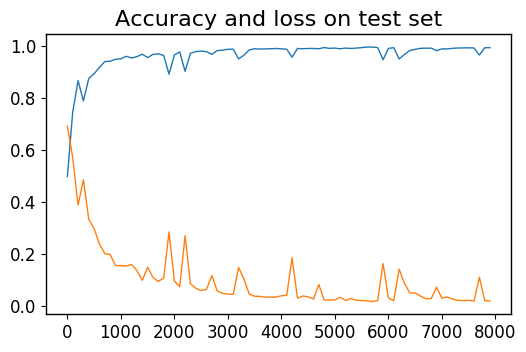

In [19]:
step, acc, loss = zip(*step_acc_loss)
plt.plot(step, acc)
plt.plot(step, loss)
plt.title('Accuracy and loss on test set')

The model works very well.

### Conventional ML model

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [21]:
LogisticRegression(C=1.0).fit(X_train, y_train).score(X_test, y_test)

0.64729999999999999

In [22]:
RandomForestClassifier(n_estimators=100).fit(X_train, y_train).score(X_test, y_test)

1.0

RF does just as well as the RNN whereas the linear model performs poorly.